In [42]:
# from mpu6050 import mpu6050
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import json
import numpy as np
from ahrs.filters import Madgwick as ahrsMadgwick
from ahrs.filters import AQUA as ahrsAQUA
from ahrs.filters import EKF as ahrsEKF
import numpy as np
import time
import math
import ahrs

def deg2rad(dat):
    return {'x': np.deg2rad(dat['x']), 'y': np.deg2rad(dat['y']), 'z': np.deg2rad(dat['z'])}
def dict2arr(dat):
    return [dat['x'], dat['y'], dat['z']]

def calib_inplace(samples, n_s=10):
    bias = {'a':{'x':0., 'y':0., 'z':9.8}, 'g':{'x':0., 'y':0., 'z':0.}}
    for device in ['a', 'g']:
        for k in ['x', 'y', 'z']:
            bias[device][k] -= sum([el[device][k] for el in samples[:n_s]])/n_s
    print(bias)
    return bias

def plot_raw(x, y, title):
    fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize= (10, 5))
    ys = [[[el['a']['x'] for el in y], [el['a']['y'] for el in y], [el['a']['z'] for el in y]],
          [[el['g']['x'] for el in y], [el['g']['y'] for el in y], [el['g']['z'] for el in y]]]
    clrs = ['r', 'g', 'b']
    x_label = "time, s"
    y_labels = ["acceleration, m/s^2", "angular, degrees/s"]
    s_titles2 = ["X", "Y", "Z"]
    s_titles1 = ["Acc", "Gyro"]

    for i in range(2):
        for j in range(3):
            axs[i][j].plot(x, ys[i][j], clrs[j])
            if i == 0 and j == 2:
                axs[i][j].plot(x, [9.8] * len(x), 'black')
            else:
                axs[i][j].plot(x, [0] * len(x), 'black')
            axs[i][j].set_title(s_titles1[i] + ": " + s_titles2[j])
            axs[i][j].set_xlabel(x_label)
            axs[i][j].set_ylabel(y_labels[i])
    fig.suptitle(title)
    plt.show()

def q2angles(qs):
    angles = []
    for q in qs:
        # pitch = math.asin(-2.0*(q[1]*q[3] - q[0]*q[2]))
        # roll = math.atan2(2.0*(q[1]*q[2] + q[0]*q[3]), q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)
        #         t2 = +2.0 * (ww * yy - zz * xx)
#         t2 = +1.0 if t2 > +1.0 else t2
#         t2 = -1.0 if t2 < -1.0 else t2
#         pitch = math.asin(t2)
        rm = ahrs.common.orientation.q2R(q)
        roll = math.atan2(rm[2][1],rm[2][2]);#-math.asin(rm[0][2])
        pitch = math.atan2(-rm[2][0], math.sqrt(rm[2][1]**2 + rm[2][2]**2))#math.atan2(-rm[1][2], rm[2][2])

        
        # ww = q[0]
        # xx = q[1]
        # yy = q[2]
        # zz = q[3]
        # t0 = +2.0 * (ww * xx + yy * zz)
        # t1 = +1.0 - 2.0 * (xx * xx + yy * yy)
        # roll = math.atan2(t0, t1)
     

        # t0 = math.sqrt(1 + 2 * (ww * yy - xx * zz))
        # t1 = math.sqrt(1 - 2 * (ww * yy - xx * zz))
        # pitch = 2 * math.atan2(t0, t1) - math.pi / 2
        
        angles.append({'pitch': math.degrees(pitch), 'roll': math.degrees(roll)}) 
    return angles

def plot_angles(x, angles, title):
    # figure = plt.figure(figsize= (10, 5))

    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize= (10, 5))
    fig.suptitle(title)
    yk = ['roll', 'pitch']
    clrs = ['c', 'm']
    x_label = "time, s"
    y_label = "degrees"
    s_titles = ["Roll", "Pitch"]

    for i in range(2):
        axs[i].plot(x, [el[yk[i]] for el in angles], clrs[i])
        axs[i].set_title(s_titles[i])
        axs[i].set_xlabel(x_label)
        axs[i].set_ylabel(y_label)
        axs[i].plot(x, [0] * len(x), 'black')
    plt.show()
    
    # plt.subplot(121)
    # plt.plot(x, [el['roll'] for el in angles], 'r')
    # plt.plot(x, [0] * len(x), 'black')
    # plt.subplot(122)
    # plt.plot(x, [el['pitch'] for el in angles], 'g')
    # plt.plot(x, [0] * len(x), 'black')
    # plt.show()

    for k in ['roll', 'pitch']:
        print(f"Avg {k}: ", "%.5lf" % (sum([el[k] for el in angles])/len(x)))
        print(f"Std {k}: ", "%.5lf" % np.std([el[k] for el in angles]), "\n")

def multiplot_angles(x, angles_n, titles):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize= (10, 5))
    # fig.suptitle(title)
    yk = ['roll', 'pitch']
    clrs = ['c', 'm', 'r', 'g', 'b', 'pink']
    # print(clrs)
    x_label = "time, s"
    y_label = "degrees"
    s_titles = ["Roll", "Pitch"]

    for i, angles in enumerate(angles_n):
        for j in range(2):
            # print(titles[i])
            if j == 0:
                axs[j].plot(x, [el[yk[j]] for el in angles], clrs[i % len(clrs)], label = titles[i])
            else:
                axs[j].plot(x, [el[yk[j]] for el in angles], clrs[i % len(clrs)])
            if i == (len(angles_n) - 1):
                axs[j].set_title(s_titles[j])
                axs[j].set_xlabel(x_label)
                axs[j].set_ylabel(y_label)
                axs[j].plot(x, [0] * len(x), 'black')
            # _patch = mpatches.Patch(color=clrs[j][i mod len(clrs[0])], label=titles[i])
            # axs[j].legend(handles=[red_patch])
    fig.legend(loc='outside upper right')
    plt.show()

def apply_madgwick(x, y, avgt, gain = 0.033):
    madgwick = ahrsMadgwick(q0 = np.tile([1., 0., 0., 0.], (1)), Dt = avgt, frequancy= avgt ** (-1),
                                    gyr= np.array([dict2arr(deg2rad(t['g'])) for t in y]),
                                    acc = np.array([dict2arr(t['a']) for t in y]),
                                    gain = gain)
    angles = q2angles(madgwick.Q)
    plot_angles(x, angles, f"Madgwick, gain = {gain}")
    return angles, "Madgwick"


def apply_aqua(x, y, avgt, alpha= 0.01, threshold= 0.9, adaptive= False):
    aqua = ahrsAQUA(q0 = np.tile([1., 0., 0., 0.], (1)), Dt = avgt, frequancy= avgt ** (-1),
                        gyr= np.array([dict2arr(deg2rad(t['g'])) for t in y]), 
                        acc = np.array([dict2arr(t['a']) for t in y]),
                       alpha= alpha, threshold= threshold, adaptive= adaptive)
    angles = q2angles(aqua.Q)
    angles = [{"pitch": -el["pitch"], "roll": -el["roll"]} for el in angles]
    plot_angles(x, angles, f"AQUA, alpha = {alpha}, threshold = {threshold}, adaptive = {adaptive}")
    return angles, "AQUA"

def apply_ekf(x, y, avgt, frame="ENU", noises=[0.5, 0.2, 0.8**2]):
    ekf = ahrsEKF(q0 = np.tile([1., 0., 0., 0.], (1)), Dt = avgt, frequancy= avgt ** (-1),
                        gyr= np.array([dict2arr(deg2rad(t['g'])) for t in y]), 
                        acc = np.array([dict2arr(t['a']) for t in y]),
                       frame = frame, noises = noises)
    angles = q2angles(ekf.Q)
    plot_angles(x, angles, f"EKF, frame = {frame}, noises = {str(noises)}")
    return angles, "EKF"

def apply_comp(x, y, avgt, alpha=0.5):
    angles = [{'roll': 0., 'pitch': 0}]
    for i in range(1, len(x)):
        # print("ggggg= ", (y[i]['g'])['y'] * avgt)
        pitch = (math.radians(angles[i-1]['pitch']) + deg2rad(y[i]['g'])['y'] * avgt) * alpha + (1 - alpha) * (math.atan(-y[i]['a']['x'] / math.sqrt(y[i]['a']['y'] ** 2 + y[i]['a']['z'] ** 2)))
        roll = (math.radians(angles[i-1]['roll']) + deg2rad(y[i]['g'])['x'] * avgt) * alpha + (1-alpha) * math.atan(y[i]['a']['y'] / math.sqrt(y[i]['a']['x'] ** 2 + y[i]['a']['z'] ** 2))
        angles.append({"roll": math.degrees(roll), "pitch": math.degrees(pitch)})
        # print(angles[i])
    plot_angles(x, angles, f"Простой комплементарный, gain = {alpha}")
    return angles, "Простой комплементарный"

In [43]:
def process_data(fp, title, calib=None, apply_algs=[apply_comp, apply_ekf, apply_aqua, apply_madgwick]):
    data = None
    #data/1000sampl_raw26.10.2023.13_21_10.json
    #data/angles10s26.10.2023.14_32_13.json
    #data/10000raw30.10.2023.14_32_10.json
    with open(fp) as f:
        data = json.load(f)
    start = data[0][0]
    x = [el[0] - start for el in data]
    tm = [x[i] - x[i-1] for i in range(1, len(x))]
    avgt = sum(tm)/len(tm)
    print("Avg time between measurements: ", "%.5lfs" % avgt)

    bias = {'a':{'x':0, 'y':0, 'z':9.8}, 'g':{'x':0, 'y':0, 'z':0}}
    d2k = {'acc': 'a', 'gyro': 'g'}
    for device in ['acc', 'gyro']:
        for k in ['x', 'y', 'z']:
            bias[d2k[device]][k] -= sum([el[1][d2k[device]][k] for el in data])/len(x)
            print(f"Avg {device} for {k}: ", "%.4lf" % (sum([el[1][d2k[device]][k] for el in data])/len(x)))
            print(f"Std {device} for {k}: ", "%.4lf" % np.std([el[1][d2k[device]][k] for el in data]), "\n")
            
    plot_raw(x, [el[1] for el in data], title)

    y = [el[1] for el in data]
    if calib is None:
        for device in ['a', 'g']:
            for k in ['x', 'y', 'z']:
                for i in range(len(y)):
                    y[i][device][k] = y[i][device][k] + bias[device][k]
        plot_raw(x, [el[1] for el in data], title + " (со смещением от среднего)")
    elif calib == "inplace":
        calib = calib_inplace([el[1] for el in data])
        for device in ['a', 'g']:
            for k in ['x', 'y', 'z']:
                for i in range(len(y)):
                    y[i][device][k] = y[i][device][k] + calib[device][k]
        plot_raw(x, [el[1] for el in data], title + " (с найденными смещениями)")
        
    elif isinstance(calib, dict):
        for device in ['a', 'g']:
            for k in ['x', 'y', 'z']:
                for i in range(len(y)):
                    y[i][device][k] = y[i][device][k] + calib[device][k]
        plot_raw(x, [el[1] for el in data], title + " (с заданными смещениями)")
    else:
        raise ValueError("unknown calib value")
        
    # cmp, cmp_t = apply_comp(x, y, avgt)
    # ef, ef_t = apply_ekf(x, y, avgt)
    # aqu, aqu_t = apply_aqua(x, y, avgt)
    # mdgw, mdgw_t = apply_madgwick(x, y, avgt)
    # multiplot_angles(x, [cmp, mdgw, aqu, ef], [cmp_t, mdgw_t, aqu_t, ef_t])
    algs_ress = []
    for el in apply_algs:
        result_, text_ = el(x, y, avgt)
        algs_ress.append((result_, text_))
    multiplot_angles(x, [el[0] for el in algs_ress], [el[1] for el in algs_ress])

    

Avg time between measurements:  0.00742s
Avg acc for x:  0.3186
Std acc for x:  0.0639 

Avg acc for y:  0.0151
Std acc for y:  0.0614 

Avg acc for z:  10.1863
Std acc for z:  0.0605 

Avg gyro for x:  -5.0153
Std gyro for x:  0.0805 

Avg gyro for y:  -2.4093
Std gyro for y:  0.0850 

Avg gyro for z:  -2.0594
Std gyro for z:  0.5725 



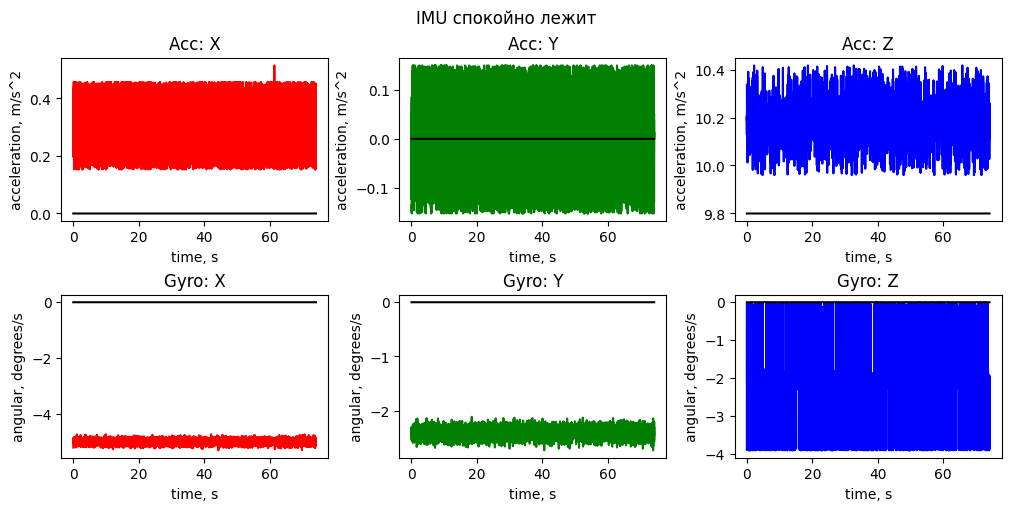

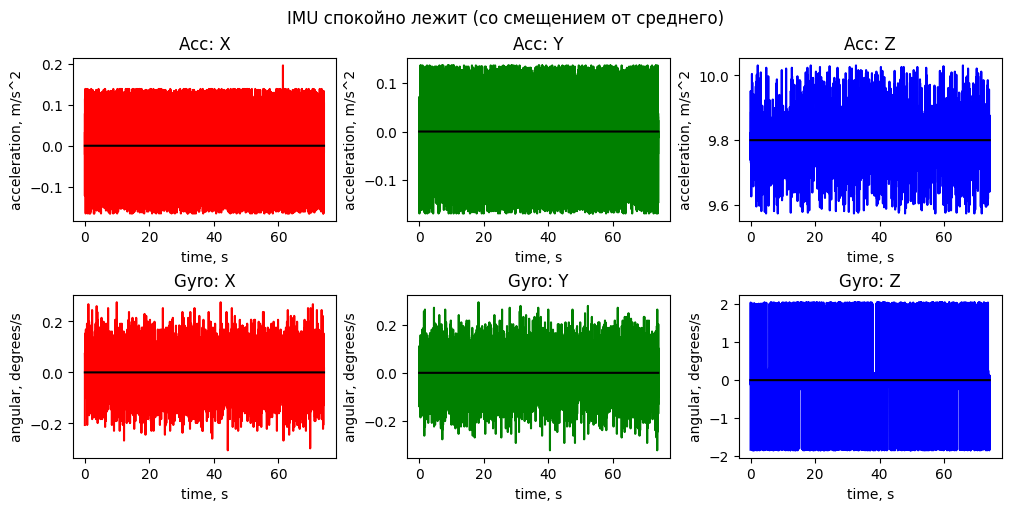

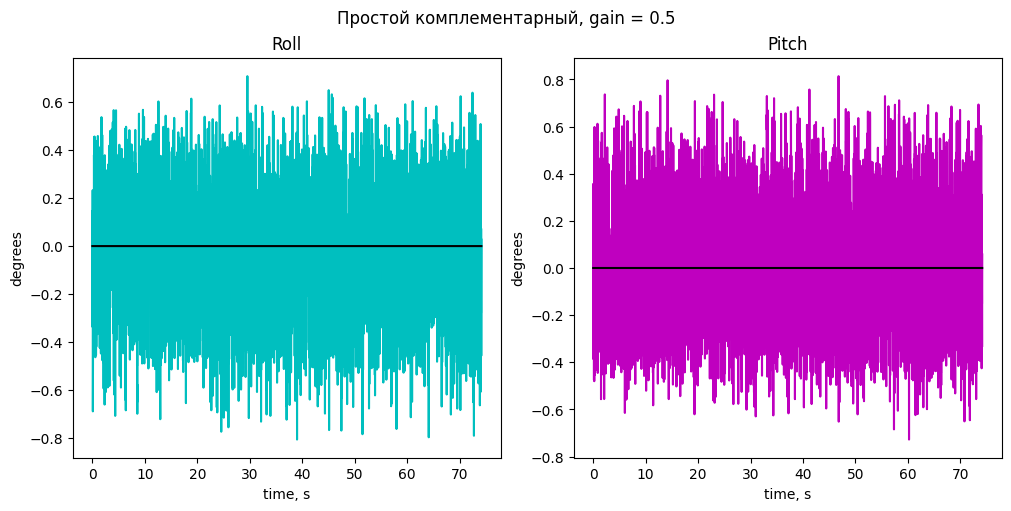

Avg roll:  -0.00004
Std roll:  0.20949 

Avg pitch:  0.00009
Std pitch:  0.21645 



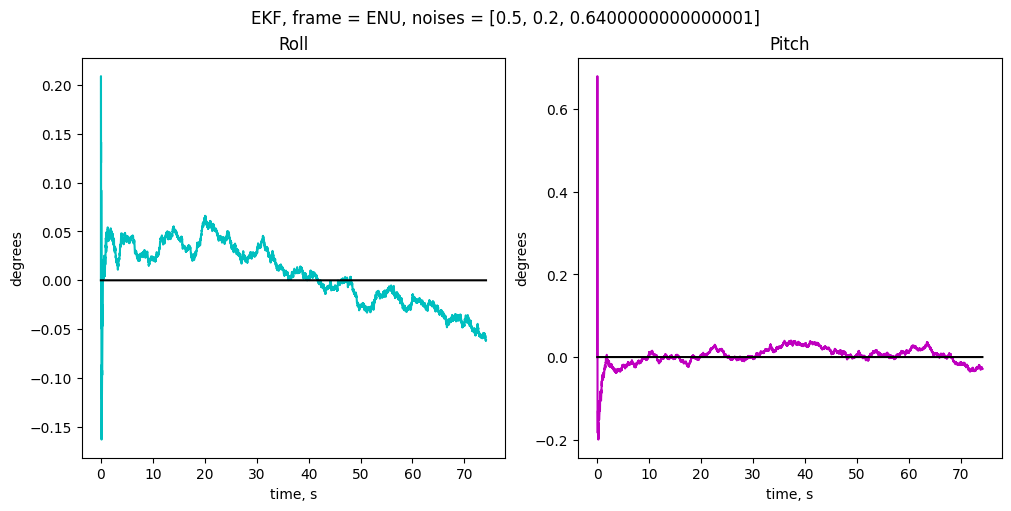

Avg roll:  0.00590
Std roll:  0.03182 

Avg pitch:  0.00283
Std pitch:  0.02253 



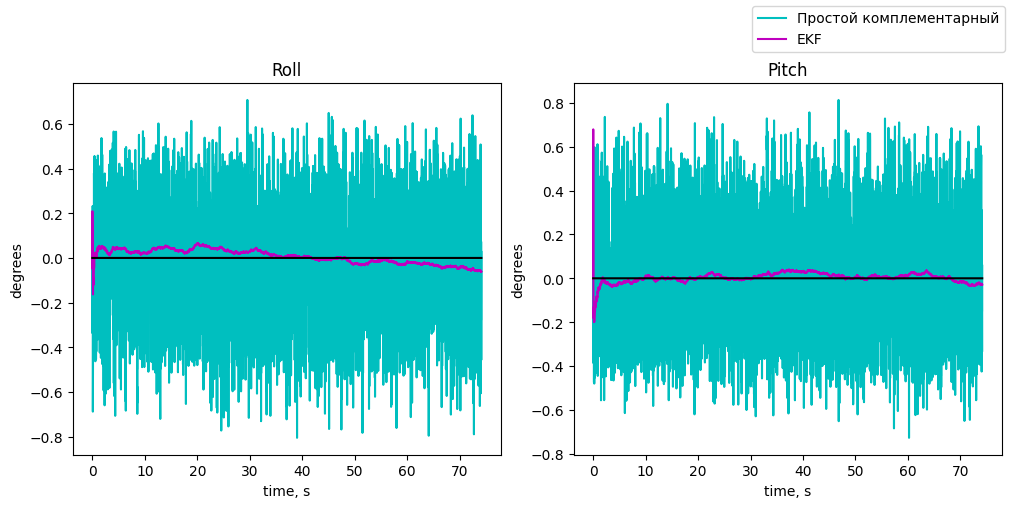

In [44]:
process_data("data/placed01.11.2023.17_39_32.json", "IMU спокойно лежит", apply_algs = [apply_comp, apply_ekf])

In [27]:
calib = {'a': {'x': -0.3186, 'y': -0.0151, 'z': 9.8 - 10.2432}, 'g': {'x': 5.0153, 'y': 2.4093, 'z': 2.0594}}

Avg time between measurements:  0.00751s
Avg acc for x:  0.3363
Std acc for x:  1.2508 

Avg acc for y:  -0.0415
Std acc for y:  1.1221 

Avg acc for z:  10.1820
Std acc for z:  0.3693 

Avg gyro for x:  -5.0380
Std gyro for x:  3.7151 

Avg gyro for y:  -2.4175
Std gyro for y:  1.5111 

Avg gyro for z:  -2.0987
Std gyro for z:  3.5885 



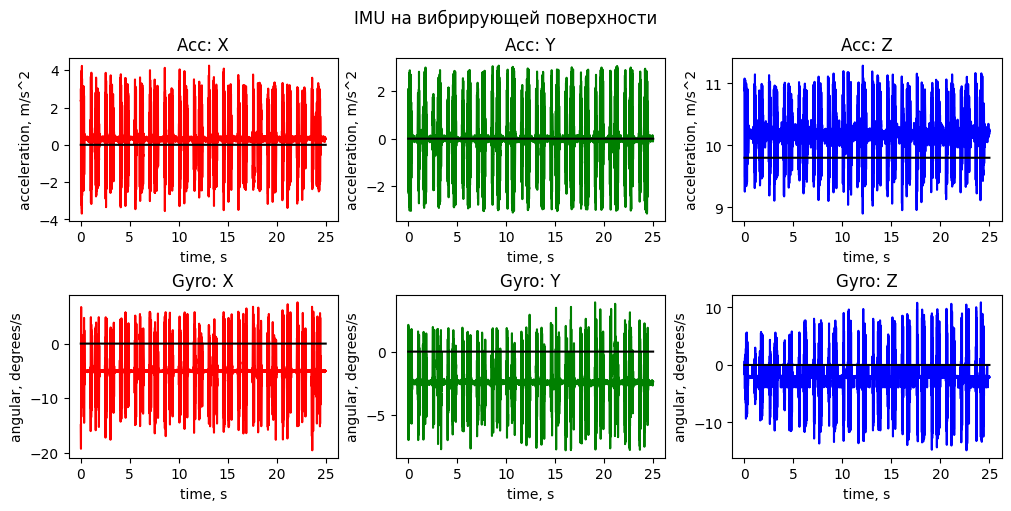

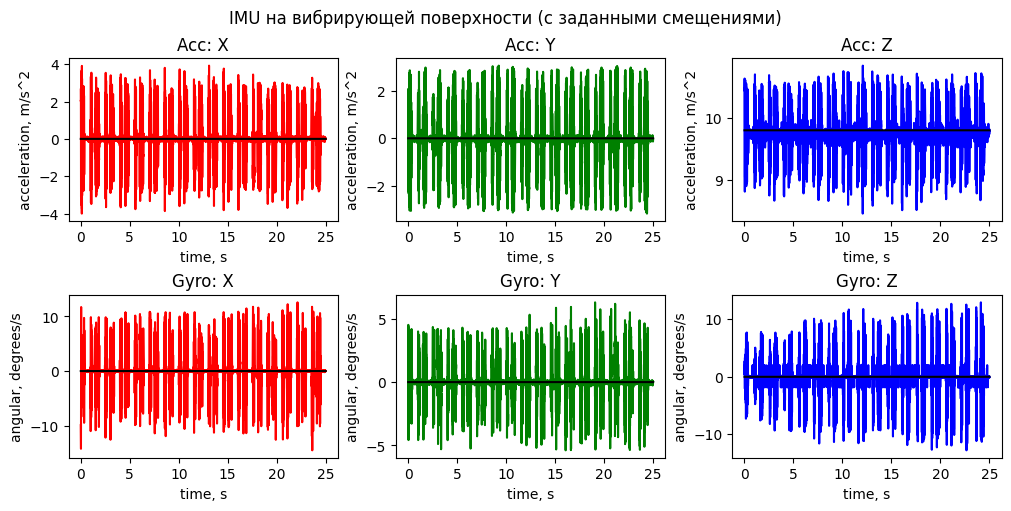

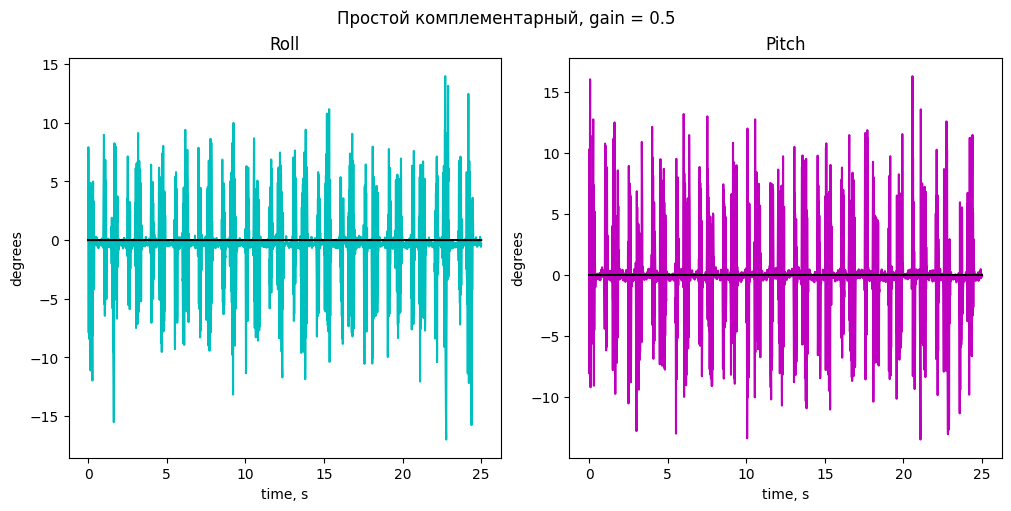

Avg roll:  -0.47886
Std roll:  3.18347 

Avg pitch:  -0.01881
Std pitch:  3.55762 



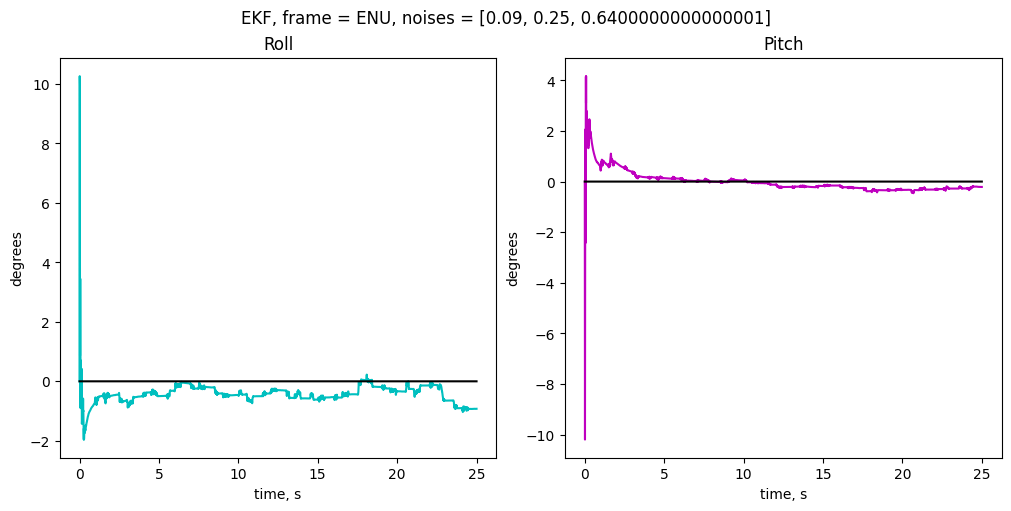

Avg roll:  -0.41805
Std roll:  0.43019 

Avg pitch:  -0.01878
Std pitch:  0.48363 



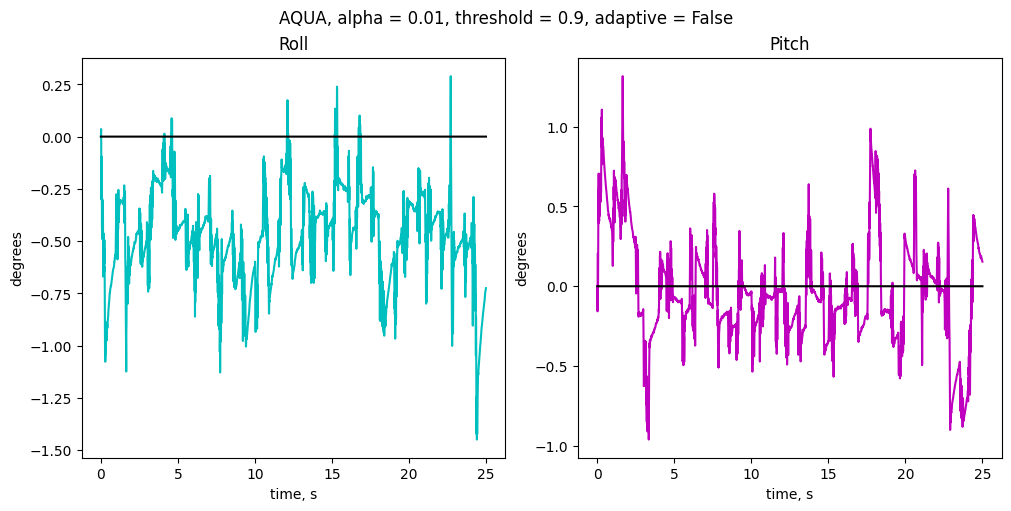

Avg roll:  -0.47660
Std roll:  0.21442 

Avg pitch:  -0.02317
Std pitch:  0.33252 



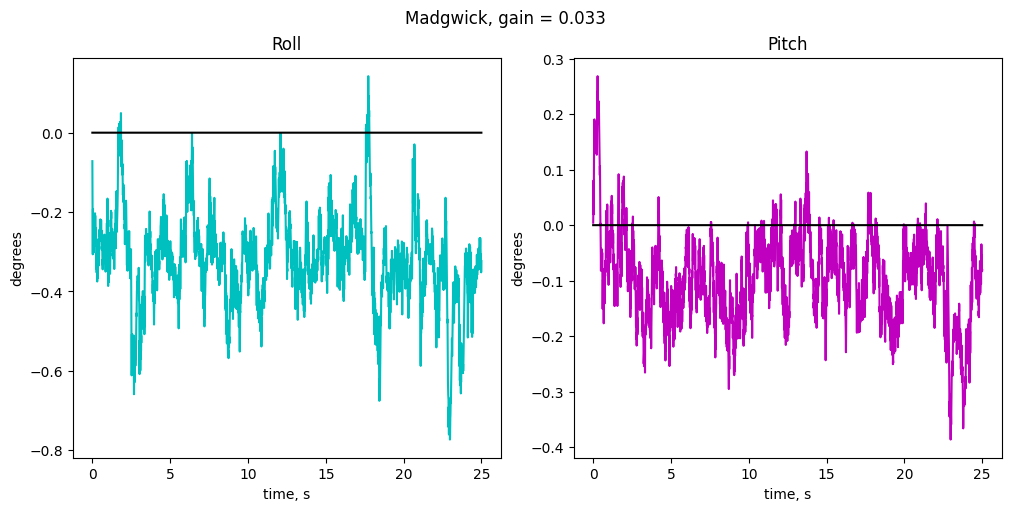

Avg roll:  -0.31889
Std roll:  0.11676 

Avg pitch:  -0.09485
Std pitch:  0.07812 



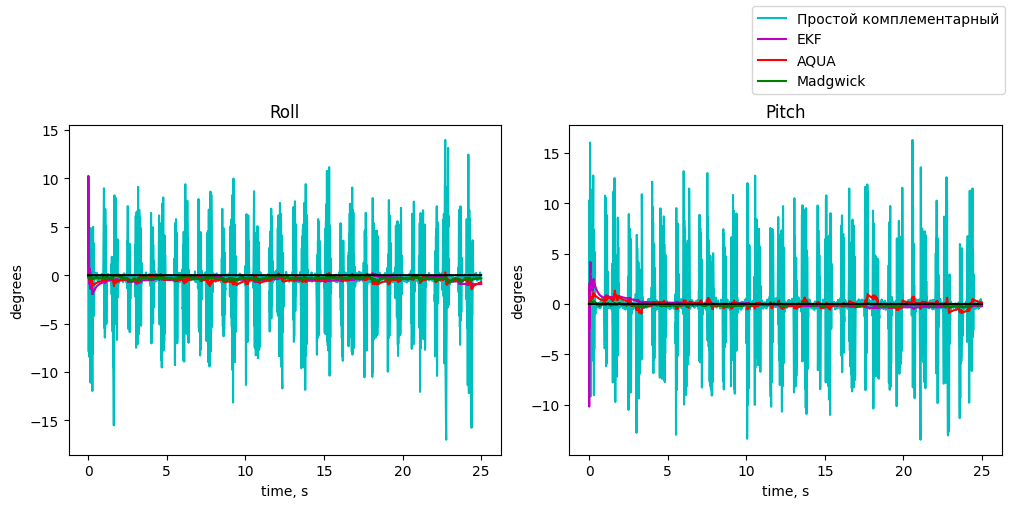

In [29]:
process_data("data/vibr01.11.2023.17_47_41.json", "IMU на вибрирующей поверхности", calib= calib)

Avg time between measurements:  0.00780s
Avg acc for x:  -0.9457
Std acc for x:  2.5183 

Avg acc for y:  -0.4212
Std acc for y:  2.3040 

Avg acc for z:  9.5553
Std acc for z:  0.8487 

Avg gyro for x:  -4.7413
Std gyro for x:  29.0748 

Avg gyro for y:  -1.9570
Std gyro for y:  20.7712 

Avg gyro for z:  -2.8996
Std gyro for z:  15.4529 



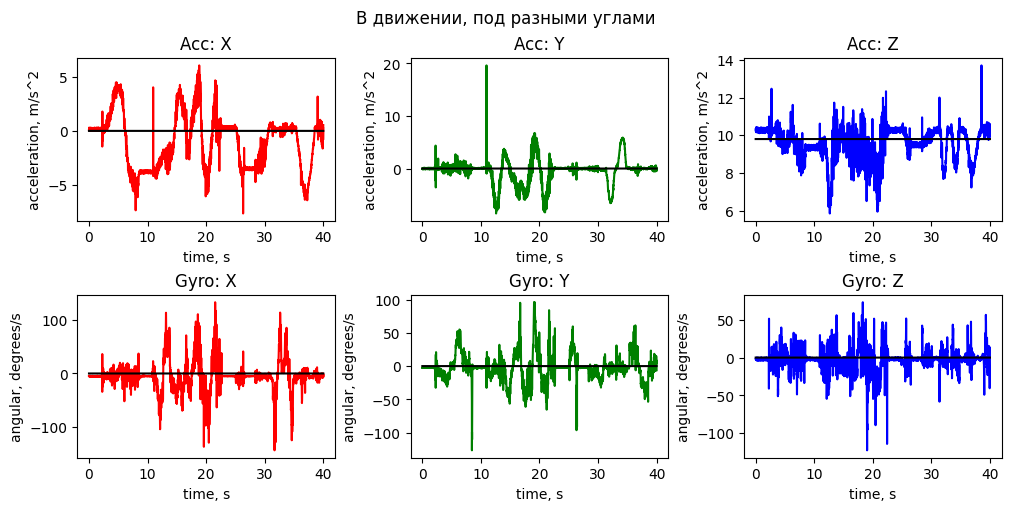

{'a': {'x': -0.15897499023437497, 'y': 0.0026336218261718758, 'z': -0.4977007604980468}, 'g': {'x': 4.953435114503817, 'y': 2.4122137404580153, 'z': 2.1557251908396946}}


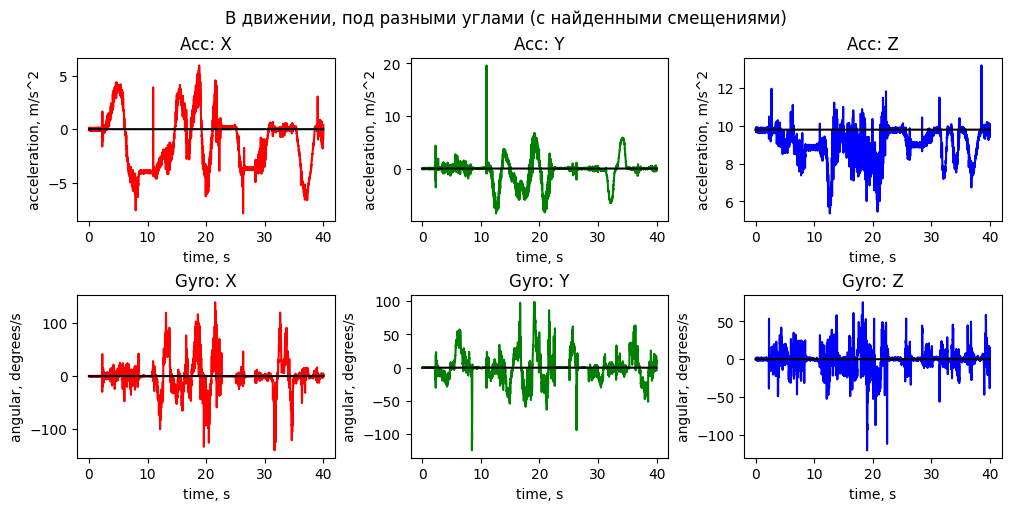

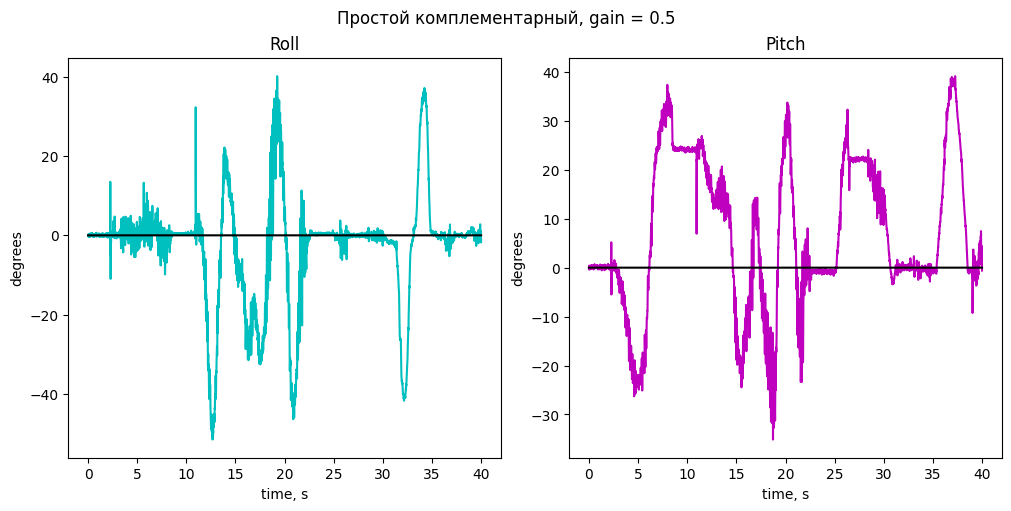

Avg roll:  -2.65070
Std roll:  13.99762 

Avg pitch:  6.75908
Std pitch:  15.23043 



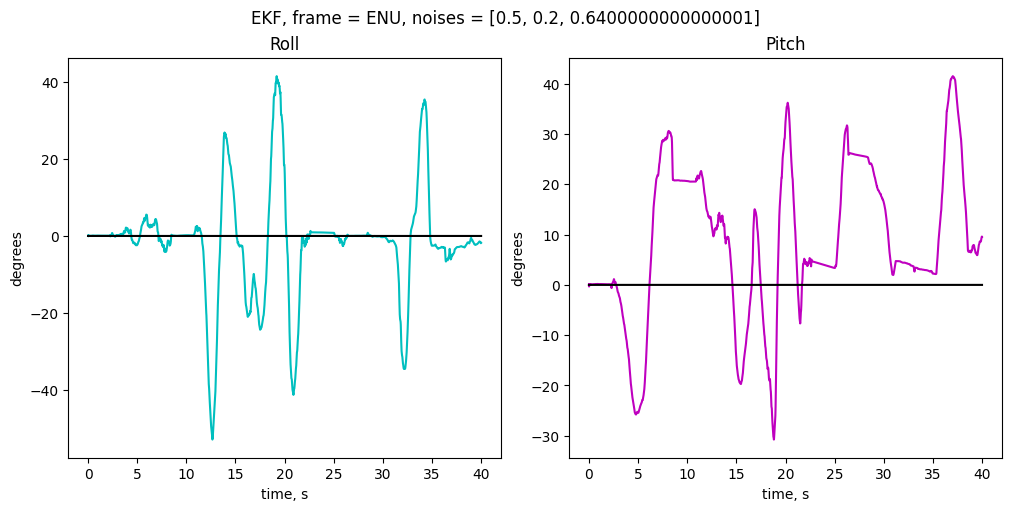

Avg roll:  -1.34084
Std roll:  14.22909 

Avg pitch:  8.24233
Std pitch:  15.13913 



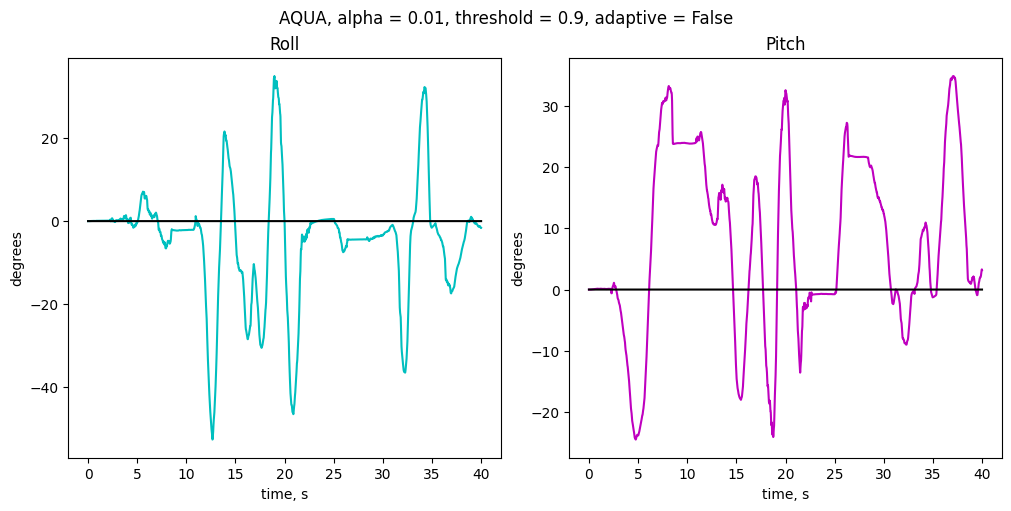

Avg roll:  -4.21769
Std roll:  14.21592 

Avg pitch:  7.24969
Std pitch:  14.63667 



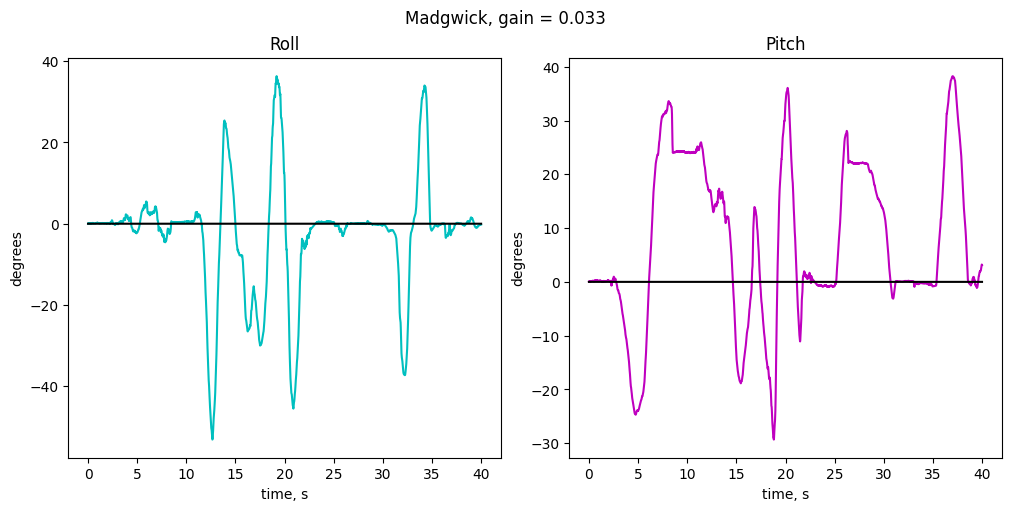

Avg roll:  -2.36567
Std roll:  14.35807 

Avg pitch:  7.18092
Std pitch:  15.20339 



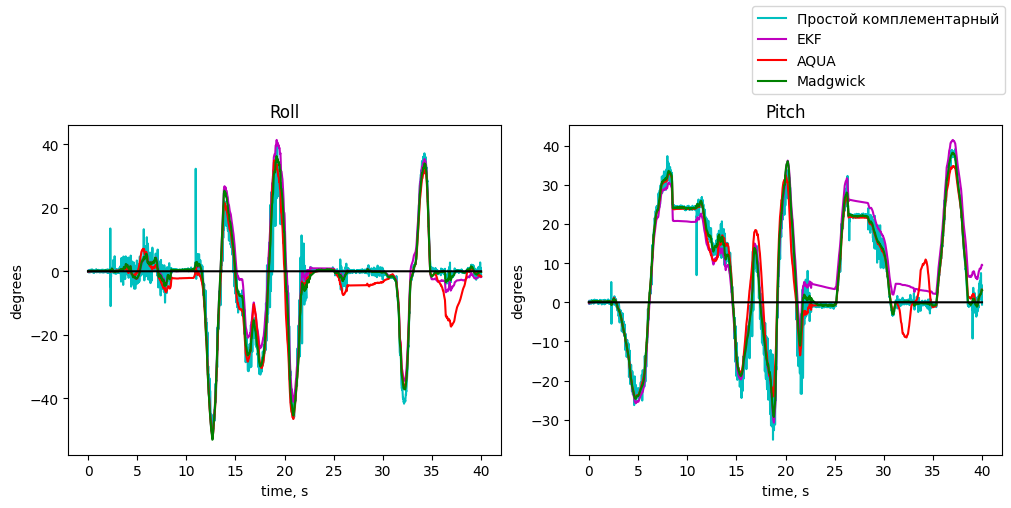

In [45]:
process_data("data/30s_move31.10.2023.18_23_43.json", "В движении, под разными углами", calib="inplace")

Avg time between measurements:  0.00750s
Avg acc for x:  0.1000
Std acc for x:  2.4815 

Avg acc for y:  0.2645
Std acc for y:  3.4476 

Avg acc for z:  9.2556
Std acc for z:  1.1936 

Avg gyro for x:  -4.6339
Std gyro for x:  48.9915 

Avg gyro for y:  -0.6117
Std gyro for y:  33.0439 

Avg gyro for z:  -1.3601
Std gyro for z:  34.2074 



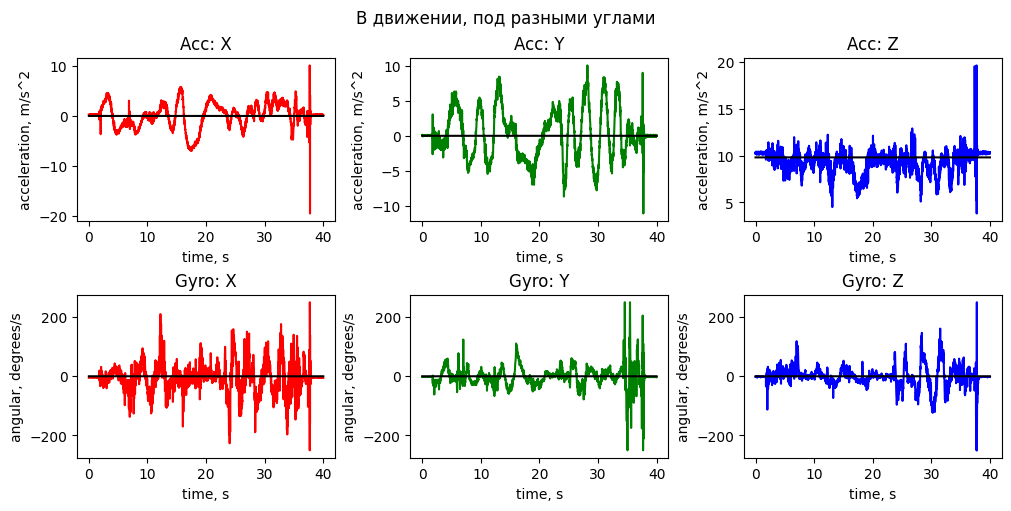

{'a': {'x': -0.21547814941406251, 'y': -0.07924807495117187, 'z': -0.4830961303710932}, 'g': {'x': 5.025190839694656, 'y': 2.4351145038167936, 'z': 2.119847328244275}}


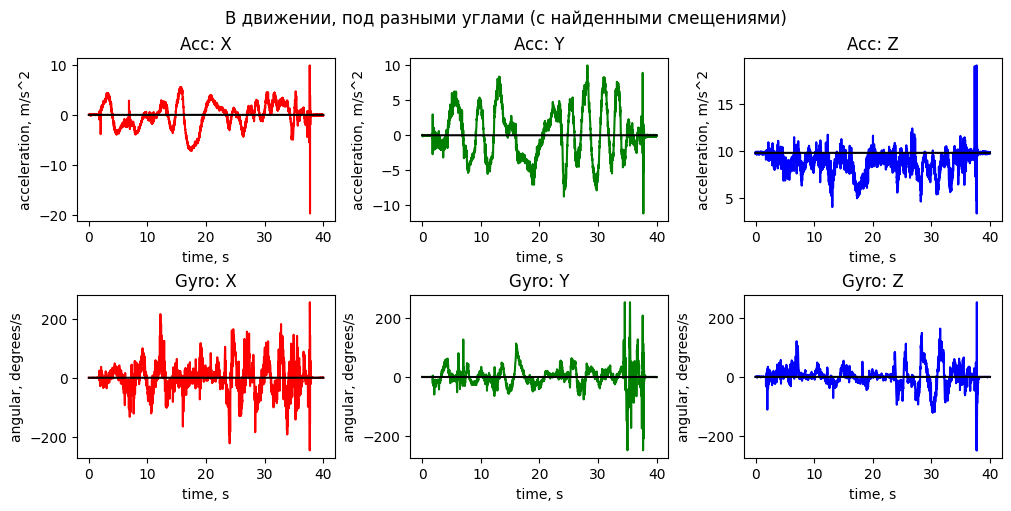

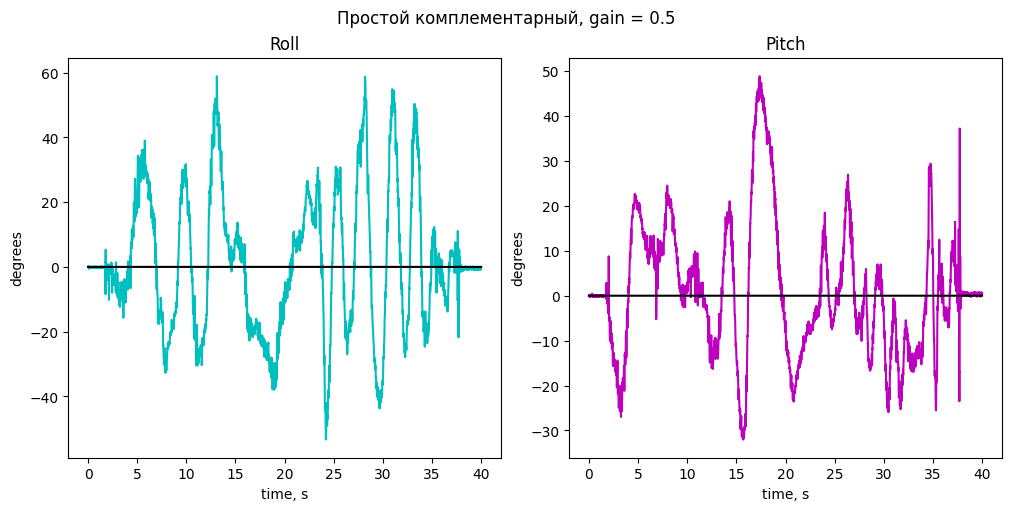

Avg roll:  1.43561
Std roll:  21.38656 

Avg pitch:  0.85343
Std pitch:  15.02091 



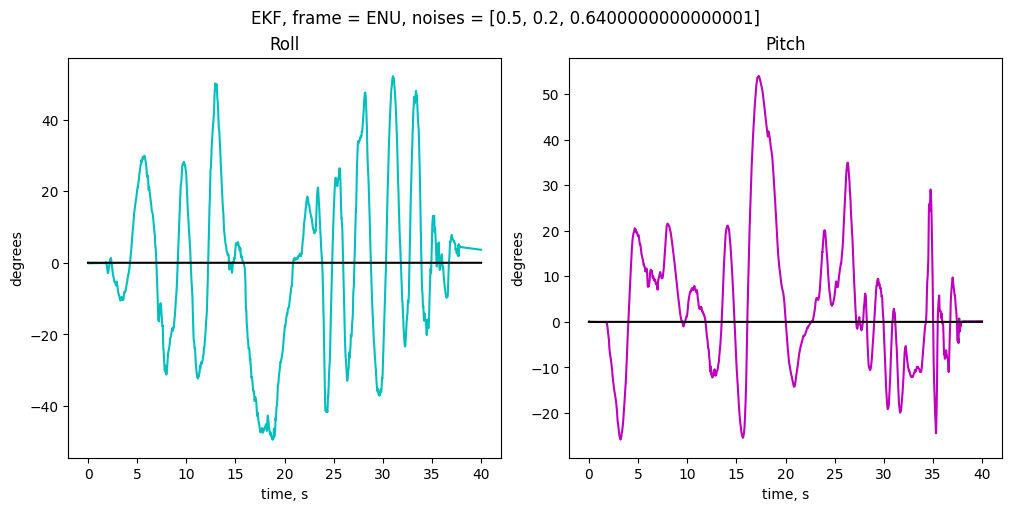

Avg roll:  -0.81047
Std roll:  22.79674 

Avg pitch:  3.83468
Std pitch:  15.63567 



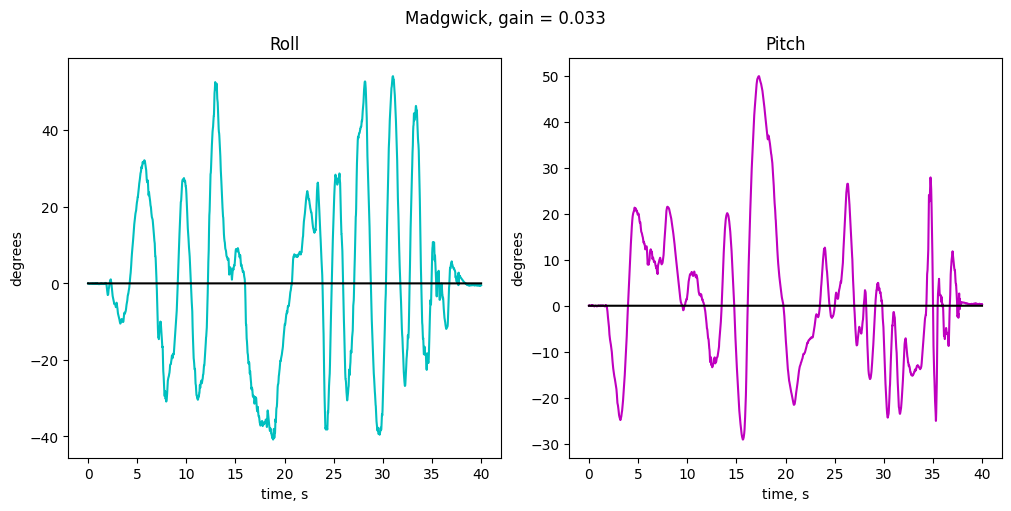

Avg roll:  0.82011
Std roll:  22.30195 

Avg pitch:  1.33018
Std pitch:  15.41097 



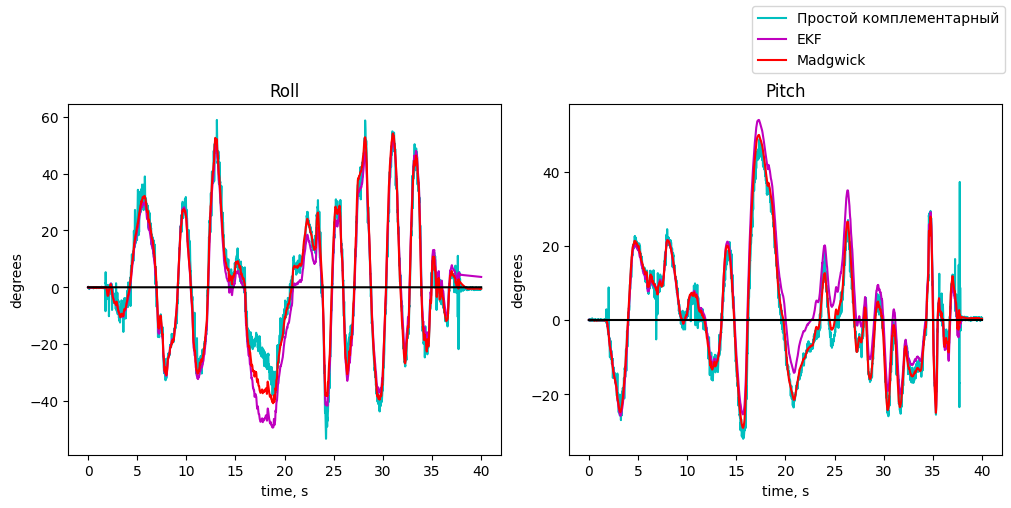

In [46]:
process_data("data/40s_flightlike31.10.2023.18_28_51.json", "В движении, под разными углами", calib="inplace", apply_algs = [apply_comp, apply_ekf, apply_madgwick])

Avg time between measurements:  0.01493s
Avg acc for x:  -0.5157
Std acc for x:  4.0280 

Avg acc for y:  -0.8241
Std acc for y:  4.0100 

Avg acc for z:  10.0327
Std acc for z:  1.9921 

Avg gyro for x:  -5.0218
Std gyro for x:  22.9004 

Avg gyro for y:  -2.1061
Std gyro for y:  17.5357 

Avg gyro for z:  -2.8924
Std gyro for z:  35.2251 



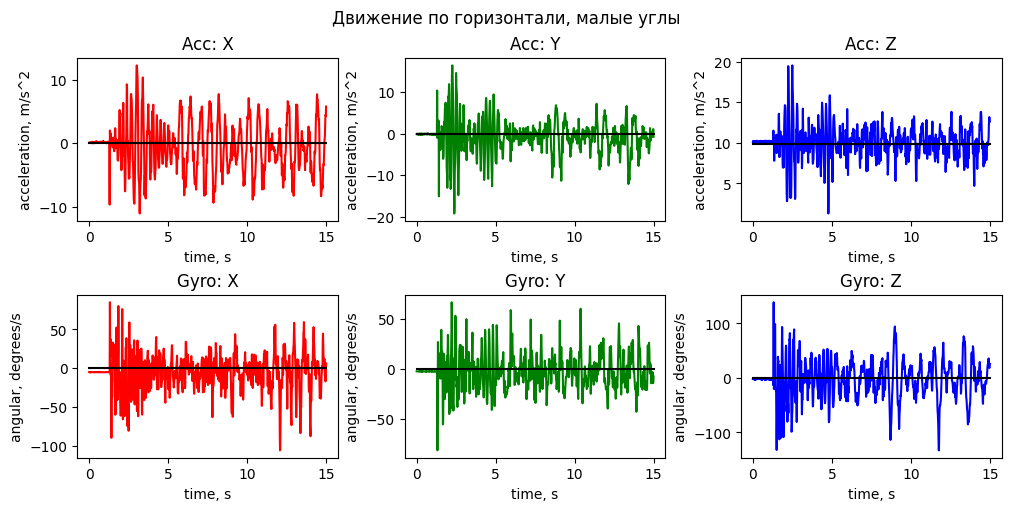

{'a': {'x': -0.1031900915527344, 'y': 0.15394716674804687, 'z': -0.3653014086914066}, 'g': {'x': 4.9946564885496185, 'y': 2.485496183206107, 'z': 1.8083969465648857}}


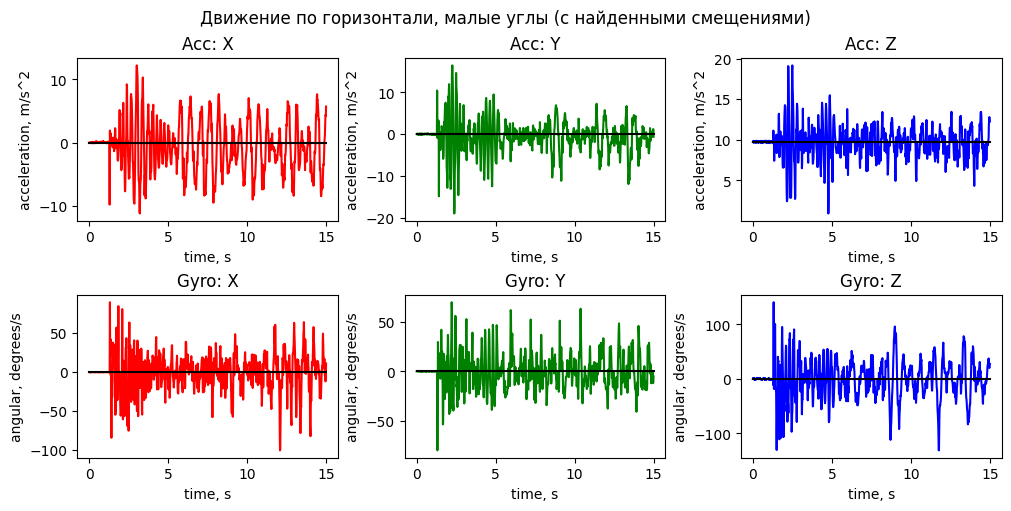

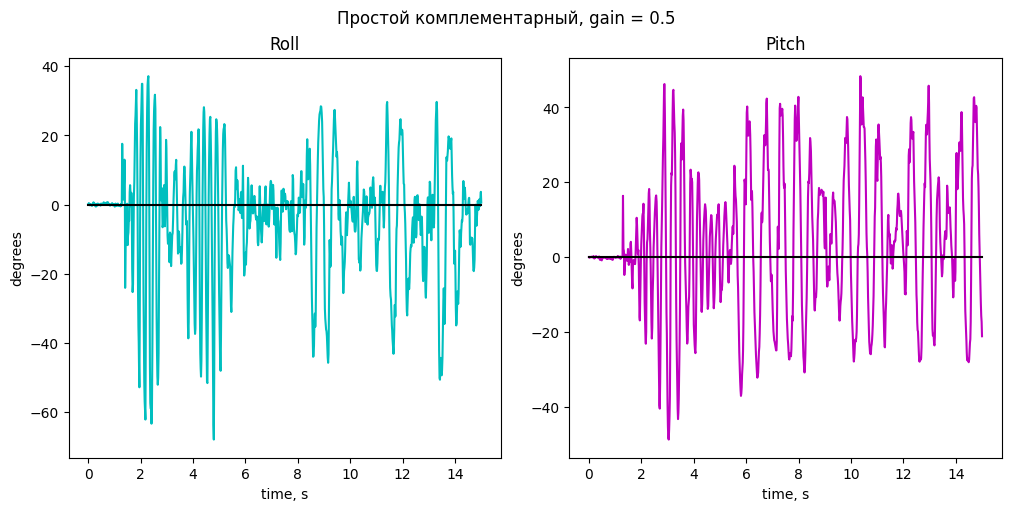

Avg roll:  -4.61419
Std roll:  17.31640 

Avg pitch:  3.84017
Std pitch:  19.31458 



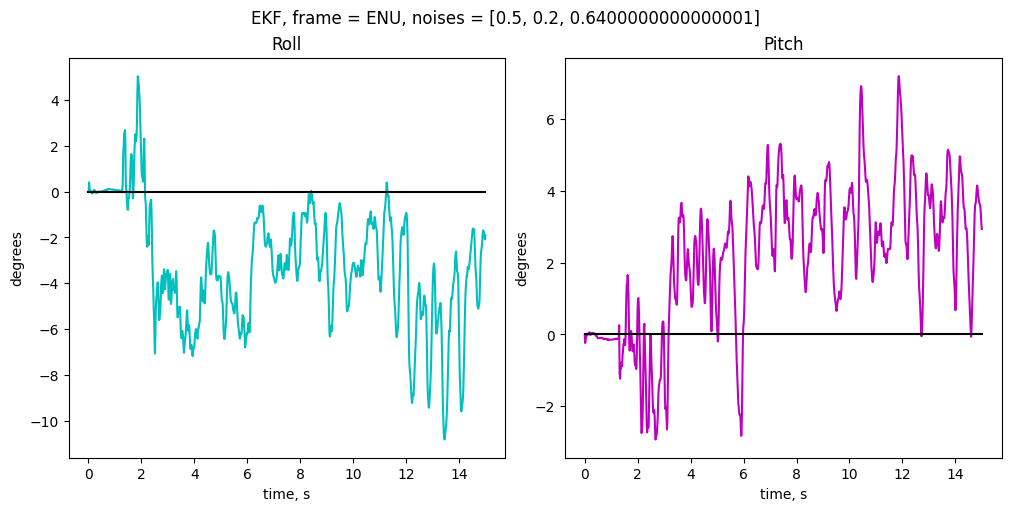

Avg roll:  -3.21365
Std roll:  2.58123 

Avg pitch:  2.16955
Std pitch:  1.99552 



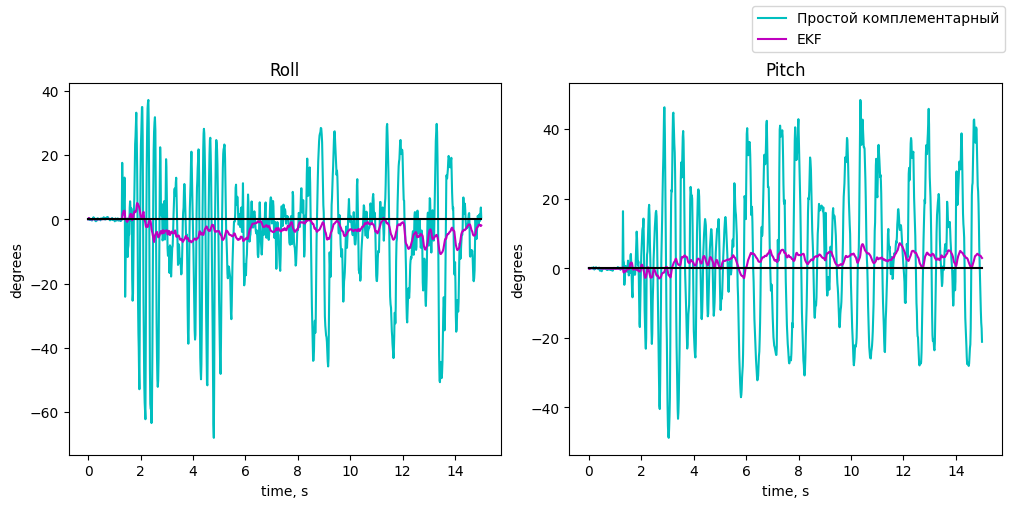

In [47]:
process_data("data/horiz_moves13.11.2023.13_15_10.json", "Движение по горизонтали, малые углы", calib="inplace", apply_algs = [apply_comp, apply_ekf])